# CN_Wheat: Nonlinear and memory-bound tasks

In [1]:
import pandas as pd
import numpy as np
import sys, os

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../'))  # for importing local packages from src

%reload_ext autoreload
%autoreload 2 

## Datasets

In [3]:
from src.model.rc_dataset import ExperimentDataset


DATASET_PATH = 'datasets/hydroshoot_large_trimmed.csv'

dataset = ExperimentDataset(csv_path=DATASET_PATH)

## Model definition

Shared model parameters for all experiments:

- Ridge regresion model
  - Fitted bias term
  - Tuned regularization parameter
  - LeaveOneGroupOut cross-validation to tune param
- Datasets
  - NEMA_H0, H3 and H15 combined as one dataset
  - Grouped by calendar day of the model inputs
- Model preprocessing
  - ~~4 days of each run are discarded as warmup days~~ **Transforms must now be applied as a pipeline with the benchmark-specific transforms!**

In [4]:
DATASET_ID = 'NEMA_combined'

In [5]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from src.learning.scorers import nmse_scorer
from pipeline_hydroshoot import GroupGenerator, TimeGenerator
from pipeline_base import TrainTestSplitter, DirectTransform, WarmupTransform


readout_model = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

model_param_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e2), 50)
}]

datasets = (dataset,)
run_ids = dataset.get_run_ids()
np.random.seed(42)
state_ids = np.random.choice(dataset.state_size(), size=16, replace=False)

warmup_days = 4

shared_pipeline_params = {
  # Data generation
  'datasets': datasets,
  'groups': GroupGenerator(day_length=24, run_ids=run_ids, days_between_runs=1),
  'time': TimeGenerator(day_length=24, run_ids=run_ids),
  
  # Model training and validation
  'readout_model': readout_model,
  'model_param_grid': model_param_grid,
  'model_scorer': nmse_scorer,
  'folds': GroupKFold(n_splits=5),
  'train_test_split': TrainTestSplitter(block_size=4, test_ratio=0.5),
}

## Benchmark pipelines

### Pipeline definitions

#### Imports

In [6]:
from pipeline_base import (
  RCPipeline, 
  Rescale, 
  DaylightMask
)

from pipeline_hydroshoot import (
  TargetGenerator, 
  SingleReservoirGenerator,
  MultiReservoirGenerator,
  TargetReservoirGenerator,
  GroupRescale
)

from model_config_hydroshoot import (
  baseline_reservoirs,
  heterogeneous_reservoirs, 
  targets, 
  state_variables
)

#### Delay line benchmark

In [7]:
from pipeline_base import DelayLineTransform, CustomWarmupTransform

def delay_line_benchmark(target_gen, target_id, res_gen, res_id, rescale, *, delay_steps: [int]):
  for d in delay_steps:
    pipeline = RCPipeline(
      metadata={
        'target_id': target_id, 
        'reservoir_id': res_id, 
        'dataset_id': DATASET_ID,
        'benchmark': 'delay_line',
        'delay': d,
      },
      # Data generation
      target=target_gen,
      reservoir=res_gen,
      # Data transformation
      transforms=[
        # NOTE: remove warmup before transform, otherwise the 
        # warmup steps are used as delayed prediction targets.
        WarmupTransform(warmup_days=4, day_length=24),
        DelayLineTransform(delay_steps=d),
      ],
      # Data preprocessing
      preprocessing=[
        DaylightMask(day_length=24, start=5, end=21),
        rescale
      ],
      **shared_pipeline_params,
    )
    yield pipeline

#### Polynomial benchmark

In [8]:
from pipeline_base import PolynomialTargetTransform

def polynomial_benchmark(target_gen, target_id, res_gen, res_id, rescale, *, exponents: [int]):
  for e in exponents:
    pipeline = RCPipeline(
      metadata={
        'target_id': target_id, 
        'reservoir_id': res_id, 
        'dataset_id': DATASET_ID,
        'benchmark': 'polynomial',
        'exponent': e,
      },
      # Data generation
      target=target_gen,
      reservoir=res_gen,
      # Data transformation
      transforms=[
        WarmupTransform(warmup_days=4, day_length=24),
        PolynomialTargetTransform(poly_coefs=[0] * e + [1]),
      ],
      # Data preprocessing
      preprocessing=[
        DaylightMask(day_length=24, start=5, end=21),
        rescale
      ],
      **shared_pipeline_params,
    )
    yield pipeline

#### NARMA benchmark

In [9]:
from pipeline_base import NarmaTargetTransform

def narma_benchmark(target_gen, target_id, res_gen, res_id, rescale, *, n_values: [int]):
  for n in n_values:
    pipeline = RCPipeline(
      metadata={
        'target_id': target_id, 
        'reservoir_id': res_id, 
        'dataset_id': DATASET_ID,
        'benchmark': 'NARMA',
        'narma_n': n,
      },
      # Data generation
      target=target_gen,
      reservoir=res_gen,
      # Data transformation
      transforms=[
        # NOTE: remove warmup before transform, otherwise the 
        # warmup steps are used as input to the NARMA system.
        WarmupTransform(warmup_days=4, day_length=24),  
        NarmaTargetTransform(n=n, scale=1),
      ],
      # Data preprocessing
      preprocessing=[
        DaylightMask(day_length=24, start=5, end=21),
        rescale
      ],
      **shared_pipeline_params,
    )
    yield pipeline

#### Near future prediction

In [10]:
def future_pred_benchmark(target_gen, target_id, res_gen, res_id, rescale, *, lookahead_steps: [int]):
  for l in lookahead_steps:
    pipeline = RCPipeline(
      metadata={
        'target_id': target_id, 
        'reservoir_id': res_id, 
        'dataset_id': DATASET_ID,
        'benchmark': 'near_future_pred',
        'lookahead': l,
      },
      # Data generation
      target=target_gen,
      reservoir=res_gen,
      # Data transformation
      transforms=[
        # NOTE: remove warmup before transform, otherwise the 
        # warmup steps are used as delayed prediction targets.
        WarmupTransform(warmup_days=4, day_length=24),
        DelayLineTransform(delay_steps=-l),
      ],
      # Data preprocessing
      preprocessing=[
        DaylightMask(day_length=24, start=5, end=21),
        rescale
      ],
      **shared_pipeline_params,
    )
    yield pipeline

### Generate pipelines

In [19]:
from itertools import chain

benchmarks = [
  # {
  #   'title': 'phys',
  #   'benchmark': delay_line_benchmark,
  #   'reservoir_id': 'state_Tlc',
  #   'reservoir_gen': SingleReservoirGenerator(state_var='state_Tlc', run_ids=run_ids, state_ids=state_ids),
  #   'target_id': 'output_E',
  #   'target_gen': TargetGenerator(target='output_E', run_ids=run_ids),
  #   'rescale': Rescale(per_feature=False),
  #   'kwargs': {
  #     'delay_steps': [0]
  #   }
  # },
  # {
  #   'title': 'phys',
  #   'benchmark': delay_line_benchmark,
  #   'reservoir_id': 'state_psi_head',
  #   'reservoir_gen': SingleReservoirGenerator(state_var='state_psi_head', run_ids=run_ids, state_ids=state_ids),
  #   'target_id': 'output_E',
  #   'target_gen': TargetGenerator(target='output_E', run_ids=run_ids),
  #   'rescale': Rescale(per_feature=False),
  #   'kwargs': {
  #     'delay_steps': [0]
  #   }
  # },
  {
    'title': 'delay_line_2h',
    'benchmark': delay_line_benchmark,
    'reservoir_id': 'state_E',
    'reservoir_gen': SingleReservoirGenerator(state_var='state_E', run_ids=run_ids, state_ids=state_ids),
    'target_id': 'output_Rg',
    'target_gen': TargetGenerator(target='output_Rg', run_ids=run_ids),
    'rescale': Rescale(per_feature=False),
    'kwargs': {
      'delay_steps': [2]
    }
  },
]

pipeline_generators = []
for benchmark in benchmarks:
  gen = benchmark['benchmark'](
    benchmark['target_gen'],
    benchmark['target_id'],
    benchmark['reservoir_gen'],
    benchmark['reservoir_id'],
    benchmark['rescale'],
    **benchmark['kwargs']
  )
  pipeline_generators.append(gen)


pipelines = list(chain(*pipeline_generators))
print(len(pipelines))

1


### Execution

In [20]:
from tqdm import tqdm
from itertools import chain
from pipeline_base import execute_pipeline



total_loops = len(pipelines)
results = []
model_data = []

with tqdm(total=total_loops) as pbar:
  for pipeline in pipelines:

    try:
      result, md = execute_pipeline(pipeline, return_model_data=True)
      results.append(result)
      model_data.append(md)
      pbar.update(1)
    except Exception as e:
      print('An exception occured executing the pipeline with the following metadata:')
      print(f'{pipeline.metadata}')
      raise e



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


### Visualization


{'target_id': 'output_Rg', 'reservoir_id': 'state_E', 'dataset_id': 'NEMA_combined', 'benchmark': 'delay_line', 'delay': 2, 'test_score': -0.2568329876662902, 'train_mean': -0.2299343640328788, 'train_std': 0.004648719177830551, 'cv_mean': -0.2372247844439282, 'cv_std': 0.020267148735197547}


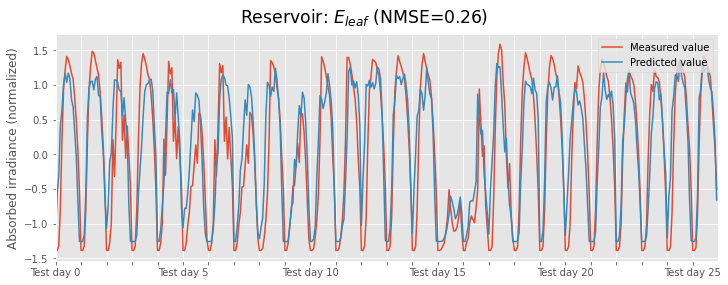

In [28]:
from model_config_hydroshoot import (input_names, measurable_reservoirs, best_reservoirs, input_symbols,
output_names, state_symbols, state_units, state_names, baseline_symbols, output_symbols)

target_names = output_names | input_names

SAMPLE_START = 16
N_SAMPLES = 15

MAX_SAMPLE = 26


for bench, scores, md in zip(benchmarks, results, model_data):
  with plt.style.context('ggplot'):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), constrained_layout=True)

    model = md['final_model']
    X_test, y_test = md['test_data']
    X_test, y_test = X_test[:MAX_SAMPLE*16], y_test[:MAX_SAMPLE*16]
    y_pred = model.predict(X_test)

    # top plot
    x_ticks = np.arange(0, len(y_test), 16)
    label_ratio = 5
    ax1.plot(y_test, label="Measured value")
    ax1.plot(y_pred, label='Predicted value')
    ax1.set_xlim(0, len(y_test))
    ax1.set_ylabel(f'{target_names[bench["target_id"]]} (normalized)')
    ax1.set_xticks(np.arange(0, len(y_test), 16))
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels([f'Test day {i}' if i % label_ratio == 0 else '' for i, _ in enumerate(x_ticks) ])
    # ax1.set_title('All test samples')
    ax1.legend(loc='upper right')

    # bottom plot
    y_test = y_test[16*SAMPLE_START:16*(SAMPLE_START + N_SAMPLES)]
    y_pred = y_pred[16*SAMPLE_START:16*(SAMPLE_START + N_SAMPLES)]
    x_ticks = np.arange(0, len(y_test), 16)
    label_ratio = 3
    ax2.plot(y_test, label="Measured value")
    ax2.plot(y_pred, label='Predicted value')
    ax2.set_xlim(0, len(y_test))
    ax2.set_ylabel(f'{target_names[bench["target_id"]]} (normalized)')
    ax2.set_xticks(np.arange(0, len(y_test), 16))
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels([f'Sample {i + SAMPLE_START}' if i % label_ratio == 0 else '' for i, _ in enumerate(x_ticks) ])
    # ax2.set_title(f'Samples {SAMPLE_START}-{SAMPLE_START + N_SAMPLES}')
    ax2.legend(loc='lower right')
    ax2.remove()



  print(scores)

  fig.suptitle(f'Reservoir: {state_symbols[bench["reservoir_id"]]} (NMSE={scores["test_score"] * -1:.2f})', fontsize='xx-large')
  plt.savefig(os.path.join('figures/', f'hydroshoot__{bench["title"]}__{bench["reservoir_id"]}__{bench["target_id"]}.png'), dpi=200, bbox_inches='tight')
  plt.show()
